## ExperiWatt - Gehirn und Energie
In diesem Arbeitsblatt lernt ihr eigenständig eine vollständige Bearbeitung, Visualisierung und Analyse von euren eigenen EEG Daten durchzuführen. Dafür benötigen wir einige Funktionen des Python Softwarepackages MNE. In dem Dokument **"MNE Funktionen"** findet ihr eine Liste an Funktionen die ihr dafür braucht.

Der Programmcode in den grau hinterlegten Felder kann durch die Tastenkomination "Strg" + "Enter" ausgeführt werden. Sie enhält außerdem **Kommentare** (gekennzeichnet durch das # -Symbol), die euch Hinweise dazu geben, welche Funktion ihr für die jeweilige Aufgabe verwenden müsst. 
Funktionen sind Programmstücke die eine bestimmte Aufgabe erfüllen. Hier ist ein Beispiel: `plot_signal(raw, start=0, end=None, electrodes=range(24)):`. Diese Funktion hat den Namen `plot_signal` und nimmt die Parameter `raw` (Daten), `start`, `end` und `electrodes`. Schaut euch beim Verwenden der Funktionen gut an welche Parameter diese Funktion braucht um zu funktionieren. Drei Punkte `...` geben euch einen Tipp wo ihr eigene Werte einsetzen müsst. 

An der Punkteanzahl die ihr für jede Aufgabe bekommt könnt ihr den Schwierigkeitsgrad der Aufgabe abschätzen. Steht dort keine Punktzahl, ist der Programmcode schon fertig und ihr müsst ihn lediglich ausführen. 

Gliederung:
1) EEG Daten laden

2) Elektroden Montage Mapping 

3) Daten Betrachtung

4) Frequenz Power Spektrum Betrachtung

5) Preprocessing (Säubern der Daten)


In [3]:
# zunächst importieren wir das MNE Package und weitere hilfreiche Programme, damit wir sie verwenden können
import mne 
from mne import viz
from mne.io import RawArray
from mne.preprocessing import ICA
from mne_icalabel import label_components
from pyprep.find_noisy_channels import find_bad_by_ransac
import matplotlib.pyplot as plt
import numpy as np
from meegkit.detrend import detrend
from meegkit.dss import dss_line
import pandas as pd

In [4]:
# Hilfreiche Funktionen (ihr könnt sie ersteinmal ignorieren)
def plot_signal(raw, start=0, end=None, electrodes=range(24)):
    sfreq = int(raw.info['sfreq'])
    start = start*sfreq
    if not end:
        end = raw.get_data().shape[1]
    else: 
        end = end*sfreq
        
    plt.plot(raw.times[start:end], raw.get_data()[electrodes, start:end].T*1e6, linewidth=0.4)
    plt.xlabel('Time [s]')
    plt.ylabel('Voltage [muV]')
    plt.title('Activity')
    plt.show()

def threshold_electrode(raw, threshold):
    '''
    threshold: value in µV
    '''

    # load electrode names 
    electrode_names = np.asarray(raw.info['ch_names'])
    
    # Find the electrode(s) over threshold
    electrodes_above_threshold = np.any(raw.get_data() > threshold*1e-6, axis=1)
    
    # Print the index(es) of the electrode(s)
    electrode_indices = np.where(electrodes_above_threshold)[0]
    print(f"Electrode(s) with values above {threshold}: Name {np.array(electrode_names[electrode_indices])}")
    
def detrend_baselines(raw):
    X = raw.get_data().T # transpose so the data is organized time-by-channels
    X, _, _ = detrend(X, order=1)
    X, _, _ = detrend(X, order=6)
    raw._data = X.T  # overwrite raw data
    raw.set_eeg_reference('average', projection=True)  #compute the reference

def detect_bad_channels(raw, corr_thresh=0.75):
    bads, _ = find_bad_by_ransac(
         data = raw.get_data(),
         sample_rate = raw.info['sfreq'],
         complete_chn_labs = np.asarray(raw.info['ch_names']),
         chn_pos = np.stack([ch['loc'][0:3] for ch in raw.info['chs']]),
         exclude = [],
         corr_thresh = corr_thresh
         )    
    return bads

def remove_bad_channels(bads, raw):
    raw_copy = raw.copy()
    raw_copy.info['bads'] = bads
    raw_copy.interpolate_bads()
    raw_copy.set_eeg_reference('average', projection=True)  #compute the reference
    raw_copy.apply_proj()
    
    return raw_copy 

def compare_power_plot(raw_passive, raw_active, fmin, fmax): 

    sfreq = reconst_raw_passive.info['sfreq']
    psds_passive, freqs = mne.time_frequency.psd_array_welch(raw_passive.get_data(), sfreq=sfreq, fmin=fmin, fmax=fmax, average='mean')
    psds_active, freqs = mne.time_frequency.psd_array_welch(raw_active.get_data(), sfreq=sfreq, fmin=fmin, fmax=fmax, average='mean')

    # Umrechnen in bezibel (µV²/Hz)
    db_psds_passive = 10 * np.log10(psds_passive / (1e-6)**2)
    db_psds_active = 10 * np.log10(psds_active / (1e-6)**2)

    fig,(ax1,ax2) = plt.subplots(ncols=2)

    im,cm = viz.plot_topomap(np.mean(db_psds_passive,1), reconst_raw_passive.info, axes=ax1, show=False)
    im,cm = viz.plot_topomap(np.mean(db_psds_active,1), reconst_raw_active.info, axes=ax2,show=False)
    ax1.set_title('Passive')
    ax2.set_title('Active')

    # Position der colorbar
    ax_x_start = 0.95
    ax_x_width = 0.04
    ax_y_start = 0.1
    ax_y_height = 0.9

    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_title("Energy",fontsize=8) # title on top of colorbar

### 1) EEG Daten laden
Um unsere Daten einsehen zu können müssen wir sie in unser Notebook laden. Danach können wir bereits einen ersten Blick auf die Daten werfen! Denke an sinnvolle Variablen benennung.

**2 Punkte**

In [5]:
# Gebt an Stelle der '...' den Namen der Datei ein, die ihr bearbeiten wollte. 
# Es ist die "fif" Datei, die ihr bei der Datenerhebung gespeichert habt
fdir = 'Experiment/output_data/'
fname_passive = 'sub-16_ses-sleepy.fif'
fname_active = 'sub-16_ses-power.fif'

# Lade die Datei. In MNE werden EEG Datensätze im "Raw" format gespeichert.
raw_passive = mne.io.read_raw_fif(fdir+fname_passive, preload=True)
raw_active = mne.io.read_raw_fif(fdir+fname_active, preload=True)

# Lösche die ersten 10 sekunden, da die Teilnehmer in der Zeit ihren Blick auf das Fixierungs-Kreuz gerichtet haben
start_time = 10
_ = raw_passive.crop(tmin=start_time)
_ = raw_active.crop(tmin=start_time)

Opening raw data file Experiment/output_data/sub-16_ses-sleepy.fif...
Isotrak not found
    Range : 0 ... 149701 =      0.000 ...   299.402 secs
Ready.


C:\Users\gross\AppData\Local\Temp\ipykernel_41436\3515624210.py:8: RuntimeWarning: This filename (Experiment/output_data/sub-16_ses-sleepy.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_passive = mne.io.read_raw_fif(fdir+fname_passive, preload=True)


Reading 0 ... 149701  =      0.000 ...   299.402 secs...
Opening raw data file Experiment/output_data/sub-16_ses-power.fif...
Isotrak not found
    Range : 0 ... 147925 =      0.000 ...   295.850 secs
Ready.
Reading 0 ... 147925  =      0.000 ...   295.850 secs...


C:\Users\gross\AppData\Local\Temp\ipykernel_41436\3515624210.py:9: RuntimeWarning: This filename (Experiment/output_data/sub-16_ses-power.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_active = mne.io.read_raw_fif(fdir+fname_active, preload=True)


### 2) Elektroden Montage Mapping
Das Softwarepackage MNE ermöglicht es uns mit einer standardisierten Map die EEG Aktivität auf die richtige Stelle auf dem Kopf zu projezieren. Die folgende Abbildung zeigt wie die Montage für das EEG System aussehen sollte.
Die Standardmontage heißt `standard_1020`.
<div>
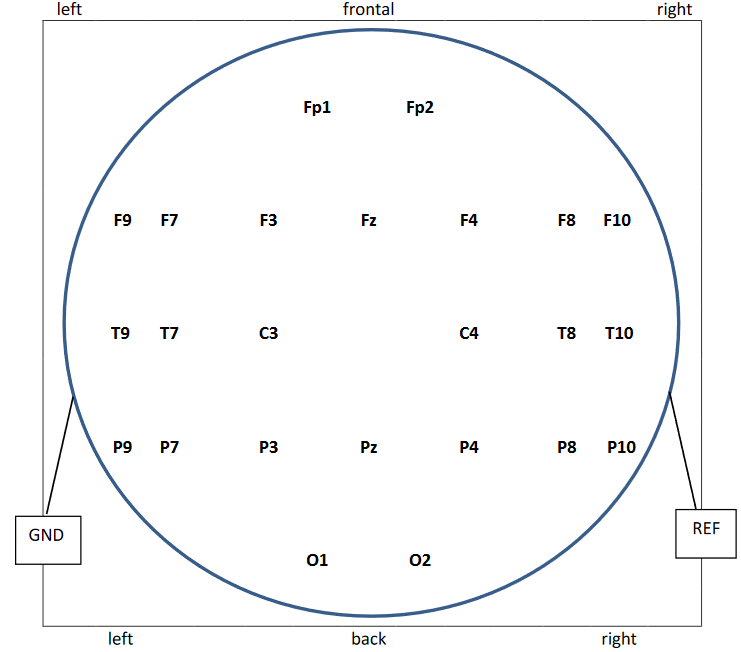
</div>

**1 Punkt**  

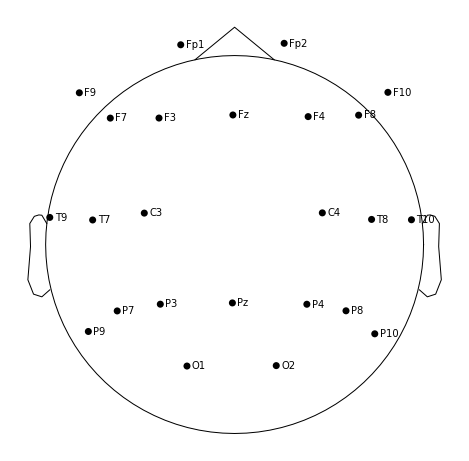

In [6]:
# Standardmontage laden und an Datensatz zufügen
montage = mne.channels.make_standard_montage('standard_1020')
raw_active.set_montage(montage)
raw_passive.set_montage(montage)

# Erstelle ein Plot der Standard Montage und vergleiche sie mit der obigen Abbildung. 
fig = raw_active.plot_sensors(show_names=True)

Kontrolliere ob die geladene Montage der Abbildung oben entspricht. 

### 3) Daten Betrachtung

Verschaffe dir einen ersten Blick in die Daten. Erstelle einen Plot der EEG Daten von 5 Kanälen über 5 Sekunden. Starte von Sekunde 10.

**3 Punkte**

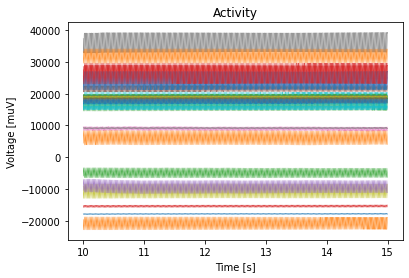

In [9]:
# Verwende dazu die mne function "plot()"
plot_signal(raw_passive, start=10, end=15, electrodes=range(24))

Falls ihr eine Elektrode (oder mehrere) entdeckt die viel höhere Werte hat als alle anderen und extrem fluktuiert, solltet ihr herausfinden welche es ist... Kanäle mit sehr schlechten Signal werden wir direkt entfernen. Später werden wir aber eine zusätzliche Analyse durchführen, um weitere schlechte Kanäle herauszufiltern. 

In [ ]:
# Dazu könnte ihr die Funktion "threshold_electrode()" verwenden
# Sie gibt an welche Elektrode über einen bestimmten Wert (threshold) gestiegen ist.
threshold_electrode(raw_active, threshold=...)

Diese Elektrode(n) könnt ihr im folgenden Schritt entfernen. Verwendet dazu die Funktion `remove_bad_channels()` und füllt für den Parameter `bads` die Namen der Elektroden mit sehr schlechtem Signal ein. ACHTUNG: Entfernt hier nur die Kanäle bei denen ihr euch sicher seid, dass sie kein gutes Signal messen konnten. Falls die Messung gut gelaufen ist, ist es gut möglich, dass ihr hier gar keine Elektrode entfernen müsst.   

In [ ]:
# Entferne Kanäle die keine Aktivität zeigen 
raw_passive = remove_bad_channels(bads=[...], raw_passive)

# Entferne Kanäle die keine Aktivität zeigen 
raw_active = remove_bad_channels(bads=[...], raw_active)

### 4) Frequenz Power Spektrum
EEG Daten sind aus Signalen von verschiedenen Frequenzen zusammengesetzt. Jede Frequenz trägt unterschiedlich viel zur gesamten Leistung des Signals bei. In diesem Aufgabenteil wollen wir herausfinden welche Frequenzen in unseren EEG Daten am stärksten vertreten sind. Mit Hilfe der sogenannten Fourier Analyse ist es möglich die Amplituden (auch Power density genannt) jeder Frequenz des EEG Signals herauszufinden. Der resultierende Graph wird auch Power Spektrum genannt.

In der folgenden Abbildung seht ihr wie ein typisches EEG Spektrum ausseht.


<div>
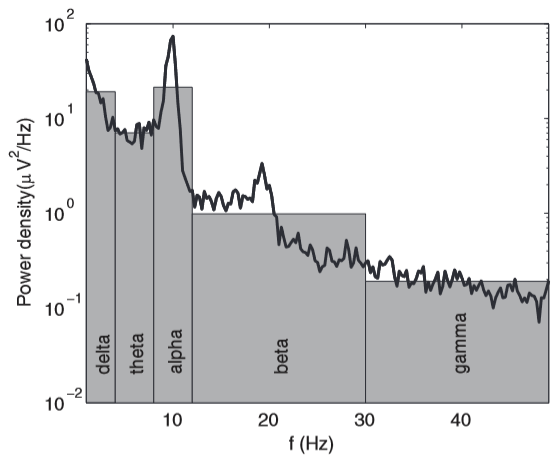
</div>

To-do:
Verwendet die `plot_psd()` Funktion (welche im Hintergrund die Fourier Analyse durchführt) um das Power Spektrum euer Daten zu berechnen, und gebt verschiedene Werte für `fmin` und `fmax` ein (niedrigste und höchste Frequenz). Vergleicht euer Spektrum mit dem obigen Beispiel (achtet auf die x-Achse) und beschreibt was ihr seht.

**1 Punkt**

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)


C:\Users\gross\AppData\Roaming\Python\Python39\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


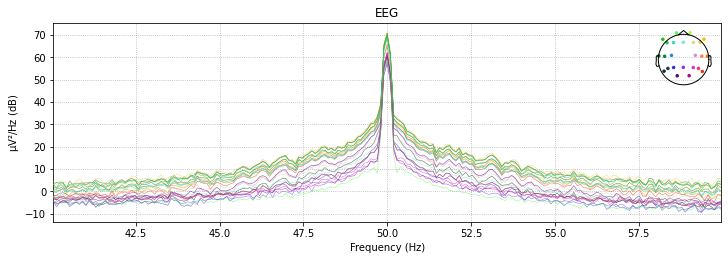

In [24]:
# Um einen solchen plot zu erstellen verwende die function "plot_psd()"
# Verwende als niedrigste Frequenz 1Hz und als höchste Frequenz 100Hz. 
# Führe dies für beide Datensets aus, das aktive und das passive. 
raw_active.plot_psd(fmin=40 , fmax=60)
plt.show()

### 5) Preprocessing
Die mit der EEG Kappe gemessene Aktivität ist leider nicht reine Gehirnaktivität. Da die Elektroden in der Kappe sehr sensitiv sind nehmen sie auch jede andere Veränderung von elektrischem Potenzial wahr. 
Wir werden die folgenden Rauschfaktoren Schritt für Schritt aus dem Signal entfernen:

5.1) Kanäle mit unzreichendem Signal

5.2) Augenblinzeln, Herzschlag und andere Muskelstörfaktoren

5.3) Stromleitungen

In [14]:
# Führt erst ein Downsampling der Datendurch, so reduziert ihr die Datenpunkte - dann geht das Bearbeiten schneller!
resample_freq = 200
_ = raw_active.resample(resample_freq)
_ = raw_passive.resample(resample_freq)

#### 5.1) Kanäle mit unzreichendem Signal behandeln

Es ist möglich, dass einige Elektroden/Kanäle die Gehirnaktivität nicht richtig messen konnten und unbrauchbar sind - bei Trockenelektroden ist es normal, dass dies circa 20% der Kanäle sind. Wir müssen herausfinden welche Kanäle betroffen sind, um sie aus unserem Datenset zu entfernen. Dafür könnt ihr die Funktion `detect_bad_channels()` verwenden. Bei dieser Methode wird die Aktivität eines Kanals durch seine Nachbarkanäle vorhergesagt. Diese Vorhersage wird mit der echten Aktivität verglichen. Einen Kanal mit schlechtem Signal erkennt man daran, dass dieser auf Grund von vielen Störfaktoren nicht vorhergesagt werden kann.

Notiere welche Kanäle detektiert wurden und schaue ob diese mit den Kanälen übereinstimmen, die euch während der Datenerhebung bereits als unzureichend aufgefallen sind.


In [15]:
# Finde Kanäle mit schlechtem signal 
bads_passive = detect_bad_channels(raw_passive, corr_thresh=0.75)
print(bads_passive)
bads_active = detect_bad_channels(raw_active, corr_thresh=0.75)
print(bads_active)

Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/57 [00:00<?,       ?it/s]


RANSAC done!
['Fp1', 'F10', 'C4', 'T10', 'P9', 'P3', 'O2']
Executing RANSAC
This may take a while, so be patient...


  0%|          |  : 0/57 [00:00<?,       ?it/s]


RANSAC done!
['T10', 'P9', 'Pz', 'P8', 'P10', 'O1', 'O2']


In [16]:
# Die Funktion "remove_bad_channels()" füllt die "Löcher" der gelöschten Kanäle durch Interpolieren der benachbarten Kanäle.
raw_passive_cleaned = remove_bad_channels(bads_passive, raw_passive)
raw_active_cleaned = remove_bad_channels(bads_active, raw_active)

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 96.8 mm
Computing interpolation matrix from 17 sensor positions
Interpolating 7 sensors
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 96.8 mm
Computing interpolation matrix from 17 sensor positions
Interpolating 7 sensors
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
Created an S

**1 Punkt**

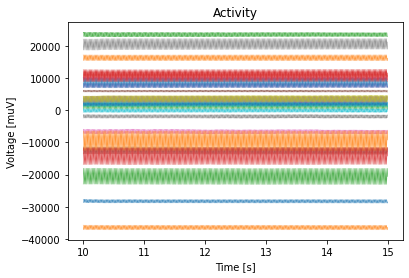

In [17]:
# Schaut euch das Signal noch einmal an und notiert was euch auffällt
plot_signal(raw_passive_cleaned, start=10, end=15, electrodes=range(24))

#### 5.2) Baseline Correction
Manche Kanäle\Elektroden weisen durch Bewegung oder Zustand der Kopfhaut (e.g. durch Schwitzen) flukturierende Hintergrundaktivität auf und müssen wieder auf die selbe Höhe gebracht werden. Diesen Vorgang nennt man Baseline Correction. Verwende hierzu die Funktion `detrend_baselines()`

**2 Punkte**

In [18]:
# Verwende die Funktion "detrend_baselines()" um die Aktivität der Baseline um die 0 mV zu bringen. 
# Als einzigen Parameter (in die Klammern der Funktion) müsst ihr den Variablennamen des Datensets eingeben. 
# Dies muss für beide Datensätze (Aktive und Passive) durchgeführt werden.
detrend_baselines(raw_passive_cleaned)
detrend_baselines(raw_active_cleaned)

EEG channel type selected for re-referencing


C:\Users\gross\AppData\Local\Temp\ipykernel_41436\4108591439.py:36: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True)  #compute the reference


EEG channel type selected for re-referencing


C:\Users\gross\AppData\Local\Temp\ipykernel_41436\4108591439.py:36: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True)  #compute the reference


**1 Punkt**

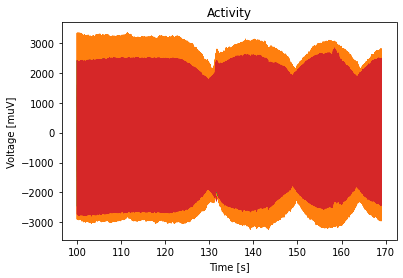

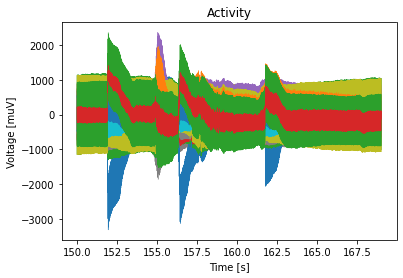

In [23]:
# Schaue dir an wie die Daten jetzt aussehen
plot_signal(raw_passive_cleaned, start=100, end=169, electrodes=range(24))
plot_signal(raw_active_cleaned, start=150, end=169, electrodes=range(24))

#### 5.3) Störungen durch Stromleitungen
Beim Betrachten des Power Density Spectrums ist euch sicher eine starke Spitze um 50Hz aufgefallen. Das sind die Wechselstromleitungen die von den EEG Elektroden aufgezeichnet werden. Damit wir dieses Signal loswerden können und dabei möglichst wenig der gemessenen Gehirnaktivität löschen, verwenden wir den sogenannten ZapLine Algorithmus. Dieser wurde in der Funktion `dss_line()` implementiert. Achtet darauf die richtige Frequenz der Stromleitung einzugeben. Passe außerdem den Parameter 'nremove' an, jenach Stärke des Störsignals. Je höher der Wert desto stärker die Filter-Wirkung

In [29]:
# Verwende "dss_line()" für das "passive" Datenset ...
X_zapline_passive, noise = dss_line(raw_passive_cleaned.get_data().T, fline=50, sfreq=raw_passive_cleaned.info['sfreq'], nremove=14)
raw_passive_zapline = RawArray(X_zapline_passive.T, raw_passive_cleaned.info)

# ... und für das "aktive"
X_zapline_active, noise = dss_line(raw_active_cleaned.get_data().T, fline=50, sfreq=raw_active_cleaned.info['sfreq'], nremove=14)
raw_active_zapline = RawArray(X_zapline_active.T, raw_active_cleaned.info)

Power of components removed by DSS: 0.99
Creating RawArray with float64 data, n_channels=24, n_times=57881
    Range : 0 ... 57880 =      0.000 ...   289.400 secs
Ready.
Power of components removed by DSS: 0.96
Creating RawArray with float64 data, n_channels=24, n_times=57170
    Range : 0 ... 57169 =      0.000 ...   285.845 secs
Ready.


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)


C:\Users\gross\AppData\Roaming\Python\Python39\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


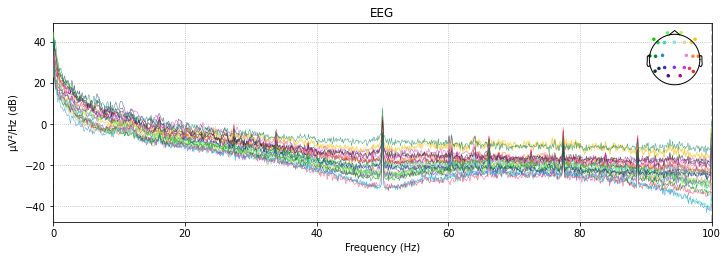

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)


C:\Users\gross\AppData\Roaming\Python\Python39\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


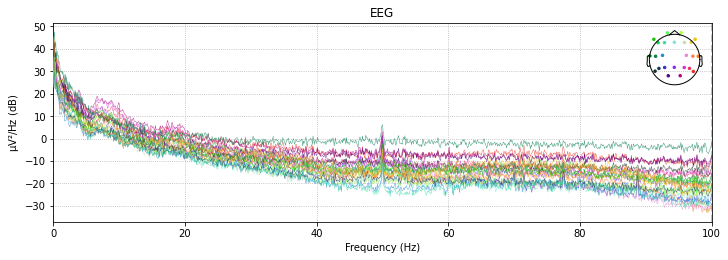

In [30]:
# Kontrolliere das Ergebnis indem du das "neue" Power Spectrum plottest. Falls du noch einen Peak bei 50Hz siest, 
# erhöhe den Wert für "nremove" in der "dss_line()" Funktion
raw_passive_zapline.plot_psd(0, 100)
plt.show()

raw_active_zapline.plot_psd(0, 100)
plt.show()

In [31]:
# Filtere außerdem die 0.5Hz Leitung aus dem Signal
raw_passive_filtered = raw_passive_zapline.copy()
_ = raw_passive_filtered.filter(l_freq=1, h_freq=None)
raw_active_filtered = raw_active_zapline.copy()
_ = raw_active_filtered.filter(l_freq=1, h_freq=None)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 661 samples (3.305 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.0s finished


**2 Punkte**

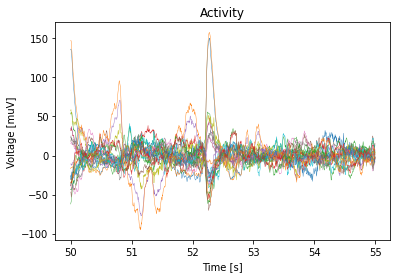

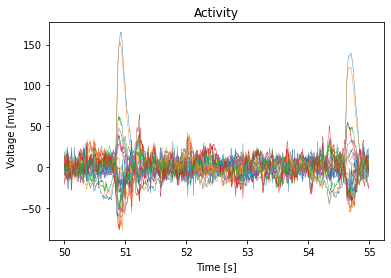

In [33]:
# Schaue dir an wie die Daten jetzt aussehen
plot_signal(raw_passive_filtered, start=50, end=55, electrodes=range(24))
plot_signal(raw_active_filtered, start=50, end=55, electrodes=range(24))

#### 4) Augenblinzeln, Herzschlag und andere Muskelstörfaktoren
In diesem Abschnitt werden wir Störfaktoren wie Augenblinzeln und den Herzschlag aufspüren, wofür wir die sogenannte Independent Component Analysis (ICA) verwenden werden. Diese Analysemethode macht es möglich individuelle Störfaktoren aufzuspüren, die auf verschiedene Kanäle verteil sein können.

In [ ]:
# Verwende ICA - passive
ica_passive = ICA(n_components=10, max_iter="auto", random_state=97)
_ = ica_passive.fit(raw_passive_filtered)

# active
ica_active = ICA(n_components=10, max_iter="auto", random_state=97)
_ = ica_active.fit(raw_active_filtered)

In [ ]:
explained_var_ratio = ica_passive.get_explained_variance_ratio(
    raw_passive_filtered, components=[3], ch_type="eeg"
)
# This time, print as percentage.
ratio_percent = round(100 * explained_var_ratio["eeg"])
print(
    f"Fraction of variance in EEG signal explained by first component: "
    f"{ratio_percent}%"
)

In [ ]:
ica_active.plot_sources(raw_active_filtered, show_scrollbars=False)
plt.show()

In [ ]:
ica_passive.plot_sources(raw_passive_filtered, show_scrollbars=False)
plt.show()

Findet heraus was für ein Signal hinter den Komponenten steckt - Gehirnaktivität, Augenzwinkern, Herzschlag, oder Rauschen. Verwendet dafür die Funktion `label_components()`

In [ ]:
ic_labels_passive = label_components(raw_passive_filtered, ica_passive, method="iclabel")
ic_labels_active = label_components(raw_active_filtered, ica_active, method="iclabel")

In [ ]:
print(ic_labels_passive["labels"])
print(ic_labels_active["labels"])

In [ ]:
# entferne nun alle ICA Komponenten, die nicht als "brain" oder "other" klassifiziert wurden. 
labels_passive = ic_labels_passive["labels"]
labels_active = ic_labels_active["labels"]
exclude_idx_passive = [
    idx for idx, label in enumerate(labels_passive) if label not in ["brain", "other"]
]
exclude_idx_active = [
    idx for idx, label in enumerate(labels_active) if label not in ["brain", "other"]
]
print(f"Excluding these ICA components: {exclude_idx_passive}")
print(f"Excluding these ICA components: {exclude_idx_active}")

In [ ]:
reconst_raw_passive = raw_passive_filtered.copy()
_ = ica_passive.apply(reconst_raw_passive, exclude=exclude_idx_passive)

reconst_raw_active = raw_active_filtered.copy()
_ = ica_active.apply(reconst_raw_active, exclude=exclude_idx_active)

Betrachtet die Daten noch einmal nach dem ihr die Preprocessing Schritte durchgeführt habt. Was hat sich verändert? 

In [ ]:
reconst_raw_active.plot()

In [ ]:
# Schaut euch an wie die Daten vorher aussehen
plot_signal(reconst_raw_active, electrodes=range(24))
plot_signal(reconst_raw_passive, electrodes=range(24))

### Topography

Als nächstes wollen wir sehen wie die gemessene Aktivität über die Elektroden (welche verschiedene Bereiche des Gehirns messen) verteilt ist. Da wir im obigen Schritt die Elektrodenposition bereits mit den Daten gelinkt haben, können wir die Aktivität nun für die ganze EEG Kappe grafisch darstellen.   

Dafür müssen wir uns erst einen Zeitpunkt aussuchen den wir betrachten wollen.

In [ ]:
%matplotlib notebook 

In [ ]:
evoked = mne.EvokedArray(np.array(reconst_raw_passive.get_data()), raw_passive_filtered.info)
times = np.arange(0.05, 0.151, 0.01)
evoked.animate_topomap(times=times, ch_type="eeg", frame_rate=2, blit=False)

In [ ]:
# wähle einen Zeitpunkt (in Sekunden)
zeitpunkt = 100
topography_data_active = np.array(reconst_raw_active.get_data())[:, zeitpunkt]
topography_data_passive = np.array(reconst_raw_passive.get_data())[:, zeitpunkt]

# Erstelle einen Topographie Plot
viz.plot_topomap(topography_data_active, raw_active.info)
viz.plot_topomap(topography_data_passive, raw_passive.info)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,2))
plt.plot(freqs, 10 * np.log10(psds.T / (1e-6)**2))
plt.show()

In [ ]:
# Begutachte das Frequenzspektrum 
reconst_raw_active.plot_psd(show=False, average=True)
reconst_raw_passive.plot_psd(show=False, average=True)
plt.show()

In [ ]:
np.min(reconst_raw_passive.compute_psd(average='mean').get_data().T)

### Energieverbrauch berechnen
Da wir jetzt wissen wie viel power jede Frequenz hat, können wir die gesamte Power von allen Frequenzen berechnen. 

In [ ]:
freqs[15]

In [ ]:
sfreq = reconst_raw_passive.info['sfreq']
psds_passive, freqs = mne.time_frequency.psd_array_welch(reconst_raw_passive.get_data(), sfreq=sfreq, fmin=1, fmax=100, average='mean')
psds_active, freqs = mne.time_frequency.psd_array_welch(reconst_raw_active.get_data(), sfreq=sfreq, fmin=1, fmax=100, average='mean')

# Umrechnen in bezibel (µV²/Hz)
db_psds_passive = 10 * np.log10(psds_passive / (1e-6)**2)
db_psds_active = 10 * np.log10(psds_active / (1e-6)**2)

energy_passive = np.sum(np.mean(db_psds_passive[:,15:45],0)**2)
energy_active =  np.sum(np.mean(db_psds_active[:,15:45],0)**2)
print("energy passive", energy_passive)
print("energy active", energy_active)

In [ ]:
total_power_passive = np.sum(np.mean(psds_passive,0)**2)
total_power_active = np.sum(np.mean(psds_active,0)**2)
print("total power passive", total_power_passive)
print("total power active", total_power_active)

In [ ]:
plt.plot(freqs, np.mean(db_psds_passive, 0), label='passive')
plt.plot(freqs, np.mean(db_psds_active, 0), label='active')
plt.legend()

In [ ]:
compare_power_plot(reconst_raw_passive, reconst_raw_active, 55, 75)

In [ ]:
# Integriere das Power Spektrum beider Datensätze
active_aplha = reconst_raw_active.copy().filter(8,10)
integrated_active = np.sum(active_aplha.get_data()**2, 1)
viz.plot_topomap(integrated_active, active_aplha.info)

In [ ]:
# Integriere das Power Spektrum beider Datensätze
passive_aplha = reconst_raw_passive.copy().filter(8,10)
integrated_passive = np.sum(passive_aplha.get_data()**2, 1)
viz.plot_topomap(integrated_passive, passive_aplha.info)

In [ ]:
reconst_active_aplha = reconst_raw_active.copy().filter(8,10)
integrated_active = np.sum(active_aplha.get_data()**2, 1)
viz.plot_topomap(integrated_active, reconst_active_aplha.info)

In [ ]:
integrated_passive